In [104]:
import numpy as np
from pylab import *
import sigproc
import glob
import os
import scipy.io
import scipy.stats

In [15]:
path = '/data/TETHYS_1/craftop/data/SB08850/20190523141715/ICS/C000'
files= glob.glob(os.path.join(path, '*.[0123]?.fil'))

In [48]:
sfs = [sigproc.SigprocFile(f) for f in files]
nsamp = 1000
startsamp = 3176000
c = 262

In [95]:
d = np.array([s[startsamp:startsamp+nsamp] for s in sfs])
nbeam, nint, nchan = d.shape
scipy.io.savemat('beamdata.mat', {'beams':d, 'nsamp':nsamp,'nbeam':nbeam, 'nchan':nchan})
print(d.shape)
dcovar = np.empty((nchan, nbeam, nbeam))
svd_u = []
svd_v = []
svd_vh = []
dout = np.empty_like(d)
rfiout = np.empty_like(d)
k = 2
 
    
for ic in range(nchan):
    r = d[:, :, ic]
    thecov = np.cov(r)
    dcovar[ic, :, :] = thecov
    u, v, vh = np.linalg.svd(thecov)
    svd_u.append(u)
    svd_v.append(v)
    svd_vh.append(vh)
    
    for  t in range(nint):
        rfi = np.dot(u.T, r[:, t])
        rfiout[:, t, ic] = rfi[:]
        rfi[:k] = 0
        dout[:, t, ic] = np.dot(rfi, u.T)


svd_u = np.array(svd_u)
svd_v = np.array(svd_v)
svd_vh = np.array(svd_vh)
dout = np.array(dout)
rfiout = np.array(rfiout)

(36, 1000, 336)


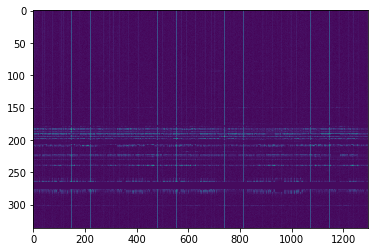

In [96]:
imshow(dcovar.reshape(nchan, -1), aspect='auto')

(250, 290)

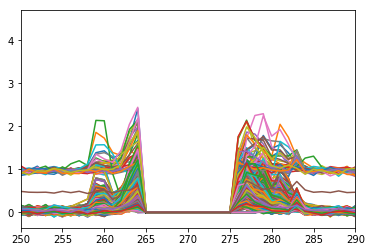

In [97]:
_= plot(dcovar.reshape(nchan, -1))
xlim(250,290)

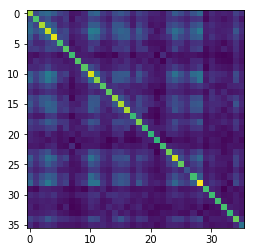

In [98]:
imshow(dcovar[c,:,:])

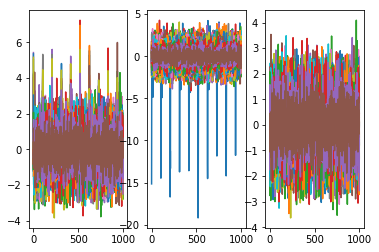

In [99]:
fig, ax = subplots(1,3)
ax[0].plot(d[:,:,c].T)
ax[1].plot(rfiout[:,:,c].T)
_ = ax[2].plot(dout[:,:,c].T)

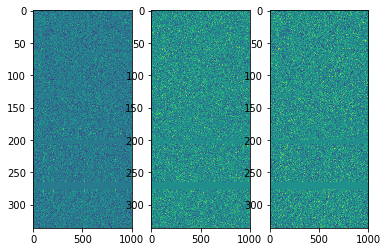

In [102]:
fig, ax = subplots(1,3)
ax[0].imshow(d[9,:,:].T, aspect='auto')
ax[1].imshow(rfiout[9,:,:].T, aspect='auto')
_ = ax[2].imshow(dout[9,:,:].T, aspect='auto')

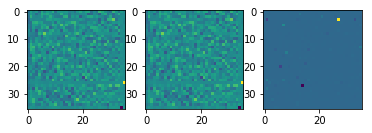

In [85]:
fig, ax = subplots(1,3)
ax[0].imshow(svd_u[c, :, :])
ax[1].imshow(svd_vh[c, :, :].T)
ax[2].imshow(svd_u[c, :, :] /svd_vh[c, :, :].T)

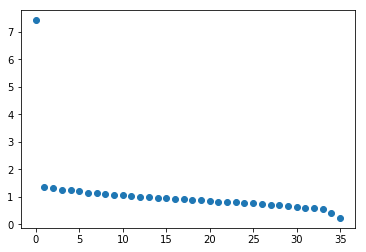

In [86]:
plot(svd_v[c, :], 'o')

(0, 5)

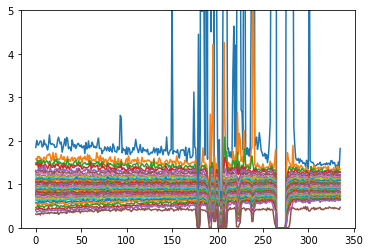

In [103]:
_ = plot(svd_v)
ylim(0,5)

In [88]:
print(rfiout.shape)

(36, 1000, 336)


In [238]:
def logliklihood(l, N):
    '''
    Log-likelihood of eigenvalues from the standard covariance signal estimation problem.
    See: Wax & Kailath 1985 equation 14
    
    Naieve implementation - can be done more efficiently by computing backwards, but don't care for now.
    :l: array of eigenvalues
    :N: number of samples in integration
    :returns: log-liklihood values for each of the eigenvalues
    '''
    p = len(l)
    out = np.zeros(p)
    for k in range(p):
        num = scipy.stats.gmean(l[k+1:])
        den = np.mean(l[k+1:])
        out[k] = (p - k)*float(N)*np.log(num/den) # Wax & Kailath has it raised to (p-k)*N power, but we use the log rule
        
        
    return out
        
    

def aic(v, N):
    '''
    Computes the Akaike information criterion from an array of eigenvalues
    See: Wax & Kailath 1985 equation 16

    :v: array of eignevalues
    '''
    p = len(v)
    ks = np.arange(p) 
    a = -2*logliklihood(v, N) + 2*ks*(2*p - ks)
    
    return a

def mdl(v, N):
    '''
    Computes the Minimum Description Length from an array of eigenvalues
    See: Wax & Kailath 1985 equation 17

    :v: array of eignevalues
    '''
    p = len(v)
    ks = np.arange(p)
    m = -logliklihood(v, N) + 0.5*ks*(2*p - ks)*np.log(N)
    
    return m

In [239]:
mdls = []
aics = []
for ic in range(nchan):
    mdls.append(mdl(svd_v[ic, :], nsamp))
    aics.append(aic(svd_v[ic, :], nsamp))

mdls = np.array(mdls)
aics = np.array(aics)
    
n_mdls = np.argmin(mdls, axis=1)
n_aics = np.argmin(aics, axis=1)
    

/home/craftop/craftenv/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0.5,0.98,'Criterion')

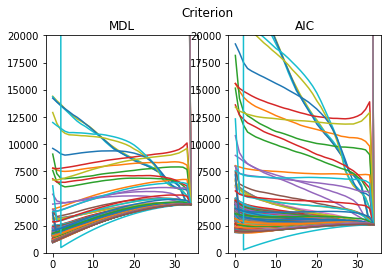

In [240]:
fig, ax = subplots(1,2)
#ax[0].imshow(mdls, aspect='auto')
#ax[1].imshow(aics, aspect='auto')
ax[0].plot(mdls.T)
_ = ax[1].plot(aics.T)
ax[0].set_ylim(0,20000)
ax[1].set_ylim(0,20000)
ax[0].set_title('MDL')
ax[1].set_title('AIC')
fig.suptitle('Criterion')



Text(0.5,0.98,'Criterion')

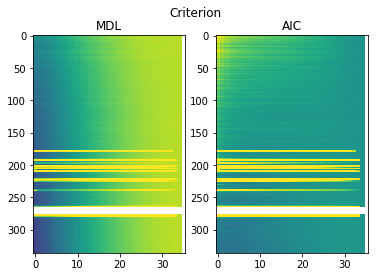

In [241]:
fig, ax = subplots(1,2)
zmin=0
zmax=5000
ax[0].imshow(mdls, aspect='auto', vmin=zmin, vmax=zmax)
ax[1].imshow(aics, aspect='auto', vmin=zmin, vmax=zmax)
ax[0].set_title('MDL')
ax[1].set_title('AIC')
fig.suptitle('Criterion')


Text(0.5,0.98,'Number of sources')

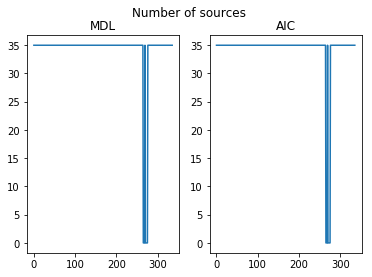

In [242]:
fig, ax = subplots(1,2)
ax[0].plot(n_mdls)
_ = ax[1].plot(n_aics)

ax[0].set_title('MDL')
ax[1].set_title('AIC')
fig.suptitle('Number of sources')


In [254]:
d = np.random.randn(1024,36)
%timeit svd(d)

100 loops, best of 3: 17.5 ms per loop


In [255]:
def corsvd(d):
    return svd(np.cov(d.T))

In [256]:
%timeit corsvd(d)

1000 loops, best of 3: 1.05 ms per loop
